MOUNT THE DRIVE AND LOAD THE DATASET

In [ ]:
#save test set predictions to a file
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

In [ ]:
#general variables
n_epochs=100
cycle_lambda = 10.
root_data = "winter_summer_dataset"

In [ ]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/CycleGAN


'/content/gdrive/My Drive/Colab Notebooks/CycleGAN'

In [ ]:
from torch.utils.data import Dataset
import numpy as np

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = torch.Tensor(np.moveaxis(np.array(Image.open(zebra_path)),-1,0)).to(torch.device("cuda:0"))/255
        horse_img = torch.Tensor(np.moveaxis(np.array(Image.open(horse_path)),-1,0)).to(torch.device("cuda:0"))/255


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"trainA"),os.path.join(root_data,"trainB"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

Text(0.5, 0, 'summer')

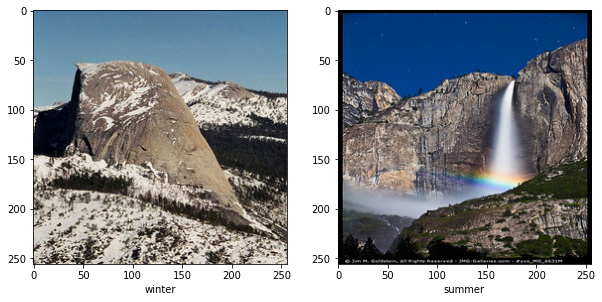

In [ ]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.xlabel("winter")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.xlabel("summer")

#MODELS

In [ ]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"),
            nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [ ]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
            Block-14          [-1, 512,

In [ ]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [ ]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,3,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [ ]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
#summary(gen,(3,256,256))
print(gen(winter))

tensor([[[-0.2616, -0.4025, -0.0377,  ..., -0.0180,  0.0102, -0.1493],
         [ 0.0627, -0.1525, -0.4223,  ..., -0.2082, -0.2229, -0.1226],
         [-0.3147, -0.1198, -0.0375,  ..., -0.1059, -0.1086, -0.1722],
         ...,
         [-0.3695, -0.4702, -0.7774,  ..., -0.3372, -0.6060,  0.0776],
         [-0.3422, -0.2415,  0.1230,  ..., -0.2629,  0.0068, -0.0075],
         [-0.5284, -0.2495, -0.3220,  ..., -0.2695, -0.2709, -0.0582]],

        [[-0.1193, -0.0201, -0.4342,  ...,  0.0037, -0.1938, -0.0161],
         [ 0.1314, -0.2013, -0.1982,  ...,  0.0759, -0.2447,  0.2636],
         [-0.0562, -0.0127, -0.4592,  ..., -0.0995,  0.0188,  0.0166],
         ...,
         [ 0.1342,  0.2282,  0.0205,  ..., -0.2119, -0.1515,  0.1374],
         [-0.4186, -0.1885, -0.2553,  ..., -0.0527,  0.0892,  0.0404],
         [-0.5701,  0.1447, -0.0548,  ..., -0.0652, -0.3221, -0.0312]],

        [[ 0.6484, -0.0409,  0.3324,  ..., -0.0255,  0.2594, -0.0307],
         [-0.0145,  0.2961,  0.0808,  ...,  0

In [ ]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))
  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.Adam(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.00004,betas=(0.5,0.999))
  opt_g = torch.optim.Adam(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.00004,betas=(0.5,0.999))

  l1 = nn.L1Loss()
  mse = nn.MSELoss()

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse

In [ ]:
import tqdm

def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse):

  for i in range(n_epochs):
    i=0
    for summer,winter in tqdm.tqdm(dataset):

      #train the discriminators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss for summer discriminator
        #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
        #basically estimating the distribution of summer images through this adversarial loss.
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer.detach())
        pred_real_summer = disc_S(summer)
        loss_disc_S_fake = mse(pred_fake_summer,torch.ones_like(pred_fake_summer))#1 means fake
        loss_disc_S_real = mse(pred_real_summer,torch.zeros_like(pred_real_summer))

        #adversarial loss for winter discriminator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter.detach())
        pred_real_winter = disc_W(winter)
        loss_disc_W_fake = mse(pred_fake_winter,torch.ones_like(pred_fake_winter))#1 means fake
        loss_disc_W_real = mse(pred_real_winter,torch.zeros_like(pred_real_winter))

        #final D loss
        D_loss = (loss_disc_S_fake + loss_disc_S_real + loss_disc_W_fake + loss_disc_W_real)/2


      opt_d.zero_grad()
      D_loss.backward()
      opt_d.step()
      
      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = mse(pred_fake_summer,torch.zeros_like(pred_fake_summer))
        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = mse(pred_fake_winter,torch.zeros_like(pred_fake_winter))

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_S(fake_summer)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      if(i==15):
        print("Gloss adv : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),"D loss : ",float(D_loss))
        i=0
      i+=1
      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()

In [ ]:
#disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse = make_the_models()


train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1, mse)

  1%|▏         | 16/1231 [00:01<02:02,  9.89it/s]

Gloss adv :  3.2238473892211914 Gloss adv :  0.575217604637146 D loss :  0.5191488265991211


  3%|▎         | 32/1231 [00:03<01:58, 10.12it/s]

Gloss adv :  2.875873565673828 Gloss adv :  0.5804908275604248 D loss :  0.484188973903656


  4%|▎         | 46/1231 [00:04<01:59,  9.95it/s]

Gloss adv :  2.471933603286743 Gloss adv :  0.6196718215942383 D loss :  0.44236406683921814


  5%|▌         | 62/1231 [00:06<01:56, 10.00it/s]

Gloss adv :  2.4778547286987305 Gloss adv :  0.7213937044143677 D loss :  0.43686792254447937


  6%|▌         | 76/1231 [00:07<01:55,  9.96it/s]

Gloss adv :  2.988478660583496 Gloss adv :  0.6528404951095581 D loss :  0.414539635181427


  7%|▋         | 92/1231 [00:09<01:53, 10.00it/s]

Gloss adv :  2.829618453979492 Gloss adv :  0.4826686978340149 D loss :  0.5750951170921326


  9%|▊         | 106/1231 [00:10<01:55,  9.74it/s]

Gloss adv :  2.6871914863586426 Gloss adv :  0.7231194972991943 D loss :  0.3756769597530365


 10%|▉         | 121/1231 [00:12<01:54,  9.74it/s]

Gloss adv :  2.5224924087524414 Gloss adv :  0.6783037185668945 D loss :  0.41063401103019714


 11%|█         | 136/1231 [00:13<01:51,  9.86it/s]

Gloss adv :  1.7933893203735352 Gloss adv :  0.5778921842575073 D loss :  0.48686715960502625


 12%|█▏        | 151/1231 [00:15<01:49,  9.87it/s]

Gloss adv :  1.8332990407943726 Gloss adv :  0.760502815246582 D loss :  0.3859499394893646


 13%|█▎        | 166/1231 [00:16<01:49,  9.68it/s]

Gloss adv :  3.191528797149658 Gloss adv :  0.7099959850311279 D loss :  0.41631174087524414


 15%|█▍        | 181/1231 [00:18<01:51,  9.43it/s]

Gloss adv :  2.379664421081543 Gloss adv :  0.6896520853042603 D loss :  0.5420589447021484


 16%|█▌        | 196/1231 [00:19<01:46,  9.74it/s]

Gloss adv :  2.3904104232788086 Gloss adv :  0.7936553955078125 D loss :  0.3996577858924866


 17%|█▋        | 211/1231 [00:21<01:45,  9.66it/s]

Gloss adv :  2.1250767707824707 Gloss adv :  0.7414727210998535 D loss :  0.4190959334373474


 18%|█▊        | 226/1231 [00:22<01:43,  9.68it/s]

Gloss adv :  2.8490757942199707 Gloss adv :  0.7027233242988586 D loss :  0.39113909006118774


 20%|█▉        | 241/1231 [00:24<01:42,  9.68it/s]

Gloss adv :  2.9141969680786133 Gloss adv :  0.5771913528442383 D loss :  0.48947441577911377


 21%|██        | 256/1231 [00:25<01:40,  9.73it/s]

Gloss adv :  2.011021137237549 Gloss adv :  0.6647915244102478 D loss :  0.419930636882782


 22%|██▏       | 271/1231 [00:27<01:39,  9.66it/s]

Gloss adv :  3.6233959197998047 Gloss adv :  0.6669147610664368 D loss :  0.4512566328048706


 23%|██▎       | 286/1231 [00:28<01:38,  9.57it/s]

Gloss adv :  2.1197268962860107 Gloss adv :  0.6324990391731262 D loss :  0.4734655022621155


 24%|██▍       | 301/1231 [00:30<01:35,  9.69it/s]

Gloss adv :  1.7359880208969116 Gloss adv :  0.6198194026947021 D loss :  0.4407845139503479


 26%|██▌       | 316/1231 [00:31<01:35,  9.61it/s]

Gloss adv :  2.0877671241760254 Gloss adv :  0.5920519828796387 D loss :  0.5115859508514404


 27%|██▋       | 332/1231 [00:33<01:32,  9.72it/s]

Gloss adv :  2.8408288955688477 Gloss adv :  0.6766231060028076 D loss :  0.4056553840637207


 28%|██▊       | 346/1231 [00:35<01:32,  9.53it/s]

Gloss adv :  1.796900749206543 Gloss adv :  0.7977229356765747 D loss :  0.36361461877822876


 29%|██▉       | 361/1231 [00:36<01:30,  9.58it/s]

Gloss adv :  2.259047746658325 Gloss adv :  0.6419080495834351 D loss :  0.4086434841156006


 31%|███       | 376/1231 [00:38<01:29,  9.58it/s]

Gloss adv :  2.2345452308654785 Gloss adv :  0.6293700337409973 D loss :  0.49277734756469727


 32%|███▏      | 391/1231 [00:39<01:27,  9.58it/s]

Gloss adv :  2.191993474960327 Gloss adv :  0.6076309680938721 D loss :  0.4872318506240845


 33%|███▎      | 406/1231 [00:41<01:26,  9.55it/s]

Gloss adv :  2.4560532569885254 Gloss adv :  0.5340994000434875 D loss :  0.552038311958313


 34%|███▍      | 421/1231 [00:42<01:24,  9.64it/s]

Gloss adv :  2.0692062377929688 Gloss adv :  0.5666235685348511 D loss :  0.4633086323738098


 35%|███▌      | 436/1231 [00:44<01:21,  9.71it/s]

Gloss adv :  1.76242995262146 Gloss adv :  0.5768791437149048 D loss :  0.5244999527931213


 37%|███▋      | 451/1231 [00:45<01:21,  9.59it/s]

Gloss adv :  2.2850990295410156 Gloss adv :  0.6130834817886353 D loss :  0.45538172125816345


 38%|███▊      | 466/1231 [00:47<01:18,  9.69it/s]

Gloss adv :  2.0404622554779053 Gloss adv :  0.6196600198745728 D loss :  0.49250298738479614


 39%|███▉      | 481/1231 [00:48<01:17,  9.65it/s]

Gloss adv :  2.339622735977173 Gloss adv :  0.6374268531799316 D loss :  0.46339964866638184


 40%|████      | 496/1231 [00:50<01:15,  9.72it/s]

Gloss adv :  1.7998402118682861 Gloss adv :  0.6728087663650513 D loss :  0.45665544271469116


 42%|████▏     | 511/1231 [00:51<01:14,  9.72it/s]

Gloss adv :  1.6782147884368896 Gloss adv :  0.7844995260238647 D loss :  0.34683096408843994


 43%|████▎     | 526/1231 [00:53<01:12,  9.71it/s]

Gloss adv :  3.2827444076538086 Gloss adv :  0.6988814473152161 D loss :  0.46674999594688416


 44%|████▍     | 541/1231 [00:54<01:11,  9.69it/s]

Gloss adv :  2.480588674545288 Gloss adv :  0.6822020411491394 D loss :  0.5094949007034302


 45%|████▌     | 556/1231 [00:56<01:09,  9.71it/s]

Gloss adv :  1.836585521697998 Gloss adv :  0.6391270160675049 D loss :  0.474101185798645


 46%|████▋     | 571/1231 [00:57<01:07,  9.72it/s]

Gloss adv :  1.792580246925354 Gloss adv :  0.6845100522041321 D loss :  0.4078710675239563


 48%|████▊     | 586/1231 [00:59<01:06,  9.70it/s]

Gloss adv :  1.8928478956222534 Gloss adv :  0.6954984068870544 D loss :  0.48594164848327637


 49%|████▉     | 601/1231 [01:00<01:04,  9.82it/s]

Gloss adv :  2.588719129562378 Gloss adv :  0.6060390472412109 D loss :  0.46679961681365967


 50%|█████     | 616/1231 [01:02<01:01,  9.95it/s]

Gloss adv :  2.2866463661193848 Gloss adv :  0.5930957198143005 D loss :  0.45790088176727295


 51%|█████▏    | 632/1231 [01:04<00:59, 10.01it/s]

Gloss adv :  2.3327889442443848 Gloss adv :  0.7314978837966919 D loss :  0.429211288690567


 52%|█████▏    | 646/1231 [01:05<00:59,  9.86it/s]

Gloss adv :  1.9955016374588013 Gloss adv :  0.7640926241874695 D loss :  0.43360769748687744


 54%|█████▎    | 661/1231 [01:06<00:57,  9.91it/s]

Gloss adv :  3.3260908126831055 Gloss adv :  0.6180598735809326 D loss :  0.455264151096344


 55%|█████▍    | 677/1231 [01:08<00:55,  9.96it/s]

Gloss adv :  3.4459357261657715 Gloss adv :  0.6214702129364014 D loss :  0.4582213759422302


 56%|█████▌    | 692/1231 [01:10<00:53, 10.00it/s]

Gloss adv :  1.856842041015625 Gloss adv :  0.6523719429969788 D loss :  0.43540942668914795


 57%|█████▋    | 707/1231 [01:11<00:53,  9.72it/s]

Gloss adv :  2.27223539352417 Gloss adv :  0.7219597101211548 D loss :  0.3597460389137268


 59%|█████▊    | 721/1231 [01:12<00:51,  9.98it/s]

Gloss adv :  1.9487932920455933 Gloss adv :  0.5932960510253906 D loss :  0.5144948959350586


 60%|█████▉    | 737/1231 [01:14<00:49,  9.99it/s]

Gloss adv :  1.370836853981018 Gloss adv :  0.6677098870277405 D loss :  0.4284346103668213


 61%|██████    | 752/1231 [01:15<00:47, 10.04it/s]

Gloss adv :  1.404308795928955 Gloss adv :  0.765987753868103 D loss :  0.32750463485717773


 62%|██████▏   | 766/1231 [01:17<00:47,  9.89it/s]

Gloss adv :  3.890049695968628 Gloss adv :  0.6136419177055359 D loss :  0.5287857055664062


 64%|██████▎   | 782/1231 [01:18<00:44, 10.02it/s]

Gloss adv :  1.735055923461914 Gloss adv :  0.5500575304031372 D loss :  0.5183045864105225


 65%|██████▍   | 797/1231 [01:20<00:43, 10.02it/s]

Gloss adv :  1.8821724653244019 Gloss adv :  0.902150571346283 D loss :  0.3320944309234619


 66%|██████▌   | 811/1231 [01:21<00:42,  9.93it/s]

Gloss adv :  2.439178943634033 Gloss adv :  0.6517234444618225 D loss :  0.42686188220977783


 67%|██████▋   | 826/1231 [01:23<00:40,  9.92it/s]

Gloss adv :  2.8029041290283203 Gloss adv :  0.6515939831733704 D loss :  0.4039361774921417


 68%|██████▊   | 842/1231 [01:25<00:41,  9.27it/s]

Gloss adv :  1.9484682083129883 Gloss adv :  0.5550554990768433 D loss :  0.5018174052238464


 70%|██████▉   | 857/1231 [01:26<00:39,  9.47it/s]

Gloss adv :  2.343204975128174 Gloss adv :  0.7142058610916138 D loss :  0.46436452865600586


 71%|███████   | 871/1231 [01:28<00:37,  9.71it/s]

Gloss adv :  1.5709455013275146 Gloss adv :  0.7293334007263184 D loss :  0.4252619743347168


 72%|███████▏  | 886/1231 [01:29<00:34,  9.91it/s]

Gloss adv :  2.0407052040100098 Gloss adv :  0.5825842618942261 D loss :  0.5504260063171387


 73%|███████▎  | 901/1231 [01:31<00:33,  9.93it/s]

Gloss adv :  2.2707467079162598 Gloss adv :  0.9526020288467407 D loss :  0.2529071569442749


 74%|███████▍  | 916/1231 [01:32<00:32,  9.84it/s]

Gloss adv :  2.1198651790618896 Gloss adv :  0.6895511150360107 D loss :  0.45930150151252747


 76%|███████▌  | 931/1231 [01:34<00:30,  9.82it/s]

Gloss adv :  2.584150791168213 Gloss adv :  0.584673285484314 D loss :  0.4402572810649872


 77%|███████▋  | 946/1231 [01:35<00:28,  9.87it/s]

Gloss adv :  1.7340281009674072 Gloss adv :  0.7316561937332153 D loss :  0.3978954553604126


 78%|███████▊  | 961/1231 [01:37<00:27,  9.71it/s]

Gloss adv :  2.227668285369873 Gloss adv :  0.7126572132110596 D loss :  0.4443245232105255


 79%|███████▉  | 976/1231 [01:38<00:25,  9.87it/s]

Gloss adv :  1.91444993019104 Gloss adv :  0.6338793039321899 D loss :  0.5094063878059387


 81%|████████  | 991/1231 [01:40<00:24,  9.80it/s]

Gloss adv :  1.9336313009262085 Gloss adv :  0.5329112410545349 D loss :  0.5326840877532959


 82%|████████▏ | 1006/1231 [01:41<00:22,  9.82it/s]

Gloss adv :  1.9051357507705688 Gloss adv :  0.7359773516654968 D loss :  0.4632036089897156


 83%|████████▎ | 1022/1231 [01:43<00:21,  9.73it/s]

Gloss adv :  3.5624353885650635 Gloss adv :  0.6217731237411499 D loss :  0.5640698671340942


 84%|████████▍ | 1036/1231 [01:44<00:20,  9.67it/s]

Gloss adv :  2.302847385406494 Gloss adv :  0.7626372575759888 D loss :  0.43607068061828613


 85%|████████▌ | 1051/1231 [01:46<00:18,  9.65it/s]

Gloss adv :  1.7409831285476685 Gloss adv :  0.7688204050064087 D loss :  0.4120038151741028


 87%|████████▋ | 1066/1231 [01:47<00:17,  9.63it/s]

Gloss adv :  2.182356119155884 Gloss adv :  0.8378872275352478 D loss :  0.3219863176345825


 88%|████████▊ | 1081/1231 [01:49<00:15,  9.69it/s]

Gloss adv :  2.4154701232910156 Gloss adv :  0.672555148601532 D loss :  0.4647883176803589


 89%|████████▉ | 1096/1231 [01:50<00:13,  9.65it/s]

Gloss adv :  1.6948699951171875 Gloss adv :  0.6910167932510376 D loss :  0.5148251056671143


 90%|█████████ | 1111/1231 [01:52<00:12,  9.76it/s]

Gloss adv :  1.9375808238983154 Gloss adv :  0.8173993825912476 D loss :  0.36364808678627014


 92%|█████████▏| 1127/1231 [01:53<00:10,  9.71it/s]

Gloss adv :  1.7848331928253174 Gloss adv :  0.7791798114776611 D loss :  0.40504133701324463


 93%|█████████▎| 1141/1231 [01:55<00:09,  9.65it/s]

Gloss adv :  2.6714444160461426 Gloss adv :  0.7727018594741821 D loss :  0.39412811398506165


 94%|█████████▍| 1156/1231 [01:56<00:07,  9.70it/s]

Gloss adv :  2.9651358127593994 Gloss adv :  0.7399169206619263 D loss :  0.3345751166343689


 95%|█████████▌| 1171/1231 [01:58<00:06,  9.65it/s]

Gloss adv :  1.6899707317352295 Gloss adv :  0.7518882155418396 D loss :  0.37659940123558044


 96%|█████████▋| 1186/1231 [01:59<00:04,  9.74it/s]

Gloss adv :  1.6975866556167603 Gloss adv :  0.8120395541191101 D loss :  0.44300413131713867


 98%|█████████▊| 1201/1231 [02:01<00:03,  9.57it/s]

Gloss adv :  2.113180637359619 Gloss adv :  0.8381940126419067 D loss :  0.43832939863204956


 99%|█████████▉| 1216/1231 [02:02<00:01,  9.58it/s]

Gloss adv :  2.0313076972961426 Gloss adv :  0.47929131984710693 D loss :  0.7003142833709717


100%|██████████| 1231/1231 [02:04<00:00,  9.32it/s]

Gloss adv :  2.490908145904541 Gloss adv :  0.8200105428695679 D loss :  0.5291440486907959


1246it [02:05,  9.73it/s]

Gloss adv :  1.7463502883911133 Gloss adv :  0.7663811445236206 D loss :  0.40911930799484253


1261it [02:07,  9.76it/s]

Gloss adv :  1.5578250885009766 Gloss adv :  0.7095035910606384 D loss :  0.5163737535476685


1276it [02:09,  9.61it/s]

Gloss adv :  2.012723922729492 Gloss adv :  0.6900147199630737 D loss :  0.4274997115135193


1291it [02:10,  9.71it/s]

Gloss adv :  2.0727779865264893 Gloss adv :  0.7364490032196045 D loss :  0.33607861399650574


1306it [02:12,  9.57it/s]

Gloss adv :  1.6881632804870605 Gloss adv :  0.5879402756690979 D loss :  0.510735809803009


1321it [02:13,  9.64it/s]

Gloss adv :  2.270754337310791 Gloss adv :  0.7725789546966553 D loss :  0.40067747235298157


1336it [02:15,  9.59it/s]

Gloss adv :  2.445784091949463 Gloss adv :  0.802558958530426 D loss :  0.37325748801231384


1351it [02:16,  9.72it/s]

Gloss adv :  1.9119771718978882 Gloss adv :  0.6773234605789185 D loss :  0.42567726969718933


1366it [02:18,  9.73it/s]

Gloss adv :  1.784265398979187 Gloss adv :  0.6551626920700073 D loss :  0.44615399837493896


1381it [02:19,  9.69it/s]

Gloss adv :  1.7362639904022217 Gloss adv :  0.8231253623962402 D loss :  0.38182973861694336


1396it [02:21,  9.78it/s]

Gloss adv :  1.8922109603881836 Gloss adv :  0.7155764102935791 D loss :  0.4137161672115326


1411it [02:22,  9.79it/s]

Gloss adv :  2.0177762508392334 Gloss adv :  0.5381028652191162 D loss :  0.6466550230979919


1426it [02:24,  9.73it/s]

Gloss adv :  2.0953285694122314 Gloss adv :  0.8448610305786133 D loss :  0.5019656419754028


1441it [02:25,  9.66it/s]

Gloss adv :  2.041713237762451 Gloss adv :  0.7112749218940735 D loss :  0.34274640679359436


1456it [02:27,  9.73it/s]

Gloss adv :  1.7889134883880615 Gloss adv :  0.8832978010177612 D loss :  0.30163484811782837


1471it [02:28,  9.78it/s]

Gloss adv :  1.8550139665603638 Gloss adv :  0.7146196365356445 D loss :  0.3194977939128876


1486it [02:30,  9.65it/s]

Gloss adv :  2.1815414428710938 Gloss adv :  0.7060924172401428 D loss :  0.433008074760437


1501it [02:31,  9.67it/s]

Gloss adv :  1.8098407983779907 Gloss adv :  0.7524645328521729 D loss :  0.43113043904304504


1517it [02:33,  9.98it/s]

Gloss adv :  1.6084954738616943 Gloss adv :  0.6172770261764526 D loss :  0.6129060983657837


1531it [02:34,  9.79it/s]

Gloss adv :  1.9676519632339478 Gloss adv :  0.7183580994606018 D loss :  0.4576302766799927


1546it [02:36,  9.73it/s]

Gloss adv :  1.7889291048049927 Gloss adv :  0.7395297288894653 D loss :  0.48946017026901245


1561it [02:37,  9.77it/s]

Gloss adv :  2.3755741119384766 Gloss adv :  0.5952903628349304 D loss :  0.497536838054657


1577it [02:39,  9.94it/s]

Gloss adv :  2.339839458465576 Gloss adv :  0.5146534442901611 D loss :  0.6025837659835815


1591it [02:40,  9.88it/s]

Gloss adv :  2.046602964401245 Gloss adv :  0.6434615850448608 D loss :  0.5045346021652222


1606it [02:42,  9.72it/s]

Gloss adv :  1.4325525760650635 Gloss adv :  0.7463668584823608 D loss :  0.4550135135650635


1621it [02:43,  9.74it/s]

Gloss adv :  1.8554185628890991 Gloss adv :  0.5960395336151123 D loss :  0.5159997940063477


1636it [02:45,  9.79it/s]

Gloss adv :  1.5337942838668823 Gloss adv :  0.633447527885437 D loss :  0.5361462831497192


1651it [02:46,  9.87it/s]

Gloss adv :  1.7326228618621826 Gloss adv :  0.687147855758667 D loss :  0.5033772587776184


1666it [02:48,  9.81it/s]

Gloss adv :  1.8384302854537964 Gloss adv :  0.6821585893630981 D loss :  0.417930543422699


1681it [02:49,  9.88it/s]

Gloss adv :  2.224299907684326 Gloss adv :  0.7347074747085571 D loss :  0.4322361946105957


1696it [02:51,  9.68it/s]

Gloss adv :  2.054551124572754 Gloss adv :  0.5889437198638916 D loss :  0.4764839708805084


1711it [02:52,  9.90it/s]

Gloss adv :  1.9945034980773926 Gloss adv :  0.679053783416748 D loss :  0.44369420409202576


1726it [02:54,  9.74it/s]

Gloss adv :  2.2049295902252197 Gloss adv :  0.671680212020874 D loss :  0.4020323157310486


1741it [02:55,  9.83it/s]

Gloss adv :  1.6916714906692505 Gloss adv :  0.8124911189079285 D loss :  0.33154502511024475


1756it [02:57,  9.84it/s]

Gloss adv :  1.7132281064987183 Gloss adv :  0.8872312903404236 D loss :  0.30040594935417175


1771it [02:58,  9.75it/s]

Gloss adv :  2.1240384578704834 Gloss adv :  0.6862831115722656 D loss :  0.4824985861778259


1786it [03:00,  9.87it/s]

Gloss adv :  1.7074344158172607 Gloss adv :  0.8519007563591003 D loss :  0.2688221037387848


1801it [03:01,  9.91it/s]

Gloss adv :  1.957291841506958 Gloss adv :  0.8649296760559082 D loss :  0.33521711826324463


1816it [03:03,  9.91it/s]

Gloss adv :  1.6228002309799194 Gloss adv :  0.6059722304344177 D loss :  0.5626097917556763


1831it [03:04,  9.71it/s]

Gloss adv :  1.2292510271072388 Gloss adv :  0.7210209965705872 D loss :  0.4425235986709595


1846it [03:06,  9.87it/s]

Gloss adv :  2.0203301906585693 Gloss adv :  0.5780781507492065 D loss :  0.49095386266708374


1861it [03:08,  9.77it/s]

Gloss adv :  1.937692403793335 Gloss adv :  0.6860400438308716 D loss :  0.3821398913860321


1876it [03:09,  9.83it/s]

Gloss adv :  1.844968557357788 Gloss adv :  0.6973917484283447 D loss :  0.5015166401863098


1891it [03:11,  9.65it/s]

Gloss adv :  1.4328501224517822 Gloss adv :  0.72087562084198 D loss :  0.3809172511100769


1906it [03:12,  9.45it/s]

Gloss adv :  1.7356979846954346 Gloss adv :  0.7047654390335083 D loss :  0.45856979489326477


1922it [03:14,  9.30it/s]

Gloss adv :  2.5071418285369873 Gloss adv :  0.763125479221344 D loss :  0.3414022922515869


1937it [03:15,  9.43it/s]

Gloss adv :  2.3592772483825684 Gloss adv :  0.8381654024124146 D loss :  0.38011062145233154


1951it [03:17,  9.72it/s]

Gloss adv :  2.0387370586395264 Gloss adv :  0.8996062278747559 D loss :  0.3298840820789337


1966it [03:18,  9.95it/s]

Gloss adv :  1.3008878231048584 Gloss adv :  0.8274326324462891 D loss :  0.4281606078147888


1981it [03:20,  9.72it/s]

Gloss adv :  2.180757999420166 Gloss adv :  0.8294708728790283 D loss :  0.3827255964279175


1996it [03:21,  9.70it/s]

Gloss adv :  1.7391767501831055 Gloss adv :  0.7897055745124817 D loss :  0.4383041262626648


2011it [03:23,  9.71it/s]

Gloss adv :  1.8935391902923584 Gloss adv :  0.6608514189720154 D loss :  0.5300487279891968


2027it [03:25,  9.96it/s]

Gloss adv :  1.4237980842590332 Gloss adv :  0.7170326709747314 D loss :  0.33640730381011963


2041it [03:26,  9.78it/s]

Gloss adv :  1.7412400245666504 Gloss adv :  0.6959120035171509 D loss :  0.44409629702568054


2056it [03:27,  9.87it/s]

Gloss adv :  1.9550158977508545 Gloss adv :  0.6967931389808655 D loss :  0.4591621160507202


2071it [03:29,  9.65it/s]

Gloss adv :  1.196804165840149 Gloss adv :  0.7560853958129883 D loss :  0.38899245858192444


2086it [03:30,  9.59it/s]

Gloss adv :  2.397944450378418 Gloss adv :  0.9660943746566772 D loss :  0.27324238419532776


2101it [03:32,  9.90it/s]

Gloss adv :  1.488020896911621 Gloss adv :  0.8368715047836304 D loss :  0.47791725397109985


2116it [03:33,  9.82it/s]

Gloss adv :  2.34907865524292 Gloss adv :  0.5529205799102783 D loss :  0.5046176314353943


2131it [03:35,  9.78it/s]

Gloss adv :  1.4589548110961914 Gloss adv :  0.7154945135116577 D loss :  0.40622398257255554


2146it [03:37,  9.81it/s]

Gloss adv :  1.4551891088485718 Gloss adv :  0.7718760967254639 D loss :  0.3968954086303711


2161it [03:38,  9.51it/s]

Gloss adv :  1.4180829524993896 Gloss adv :  0.7076577544212341 D loss :  0.43980687856674194


2176it [03:40,  9.83it/s]

Gloss adv :  1.6759052276611328 Gloss adv :  0.8141244649887085 D loss :  0.3323628306388855


2191it [03:41,  9.67it/s]

Gloss adv :  1.8143404722213745 Gloss adv :  0.9609808325767517 D loss :  0.43973827362060547


2206it [03:43,  9.92it/s]

Gloss adv :  1.7114335298538208 Gloss adv :  0.6884942054748535 D loss :  0.4716375470161438


2221it [03:44,  9.74it/s]

Gloss adv :  1.6333870887756348 Gloss adv :  0.8122516870498657 D loss :  0.39333397150039673


2236it [03:46,  9.70it/s]

Gloss adv :  2.738009452819824 Gloss adv :  0.6472241282463074 D loss :  0.5118680000305176


2251it [03:47,  9.70it/s]

Gloss adv :  2.1219656467437744 Gloss adv :  0.7946974039077759 D loss :  0.3616853952407837


2266it [03:49,  9.74it/s]

Gloss adv :  1.266230583190918 Gloss adv :  0.5878299474716187 D loss :  0.5907131433486938


2281it [03:50,  9.60it/s]

Gloss adv :  2.046436071395874 Gloss adv :  0.6741242408752441 D loss :  0.4379768967628479


2296it [03:52,  9.68it/s]

Gloss adv :  1.3435603380203247 Gloss adv :  1.0450137853622437 D loss :  0.23174883425235748


2311it [03:53,  9.61it/s]

Gloss adv :  1.8163235187530518 Gloss adv :  0.5721191167831421 D loss :  0.5459284782409668


2326it [03:55,  9.83it/s]

Gloss adv :  1.7804988622665405 Gloss adv :  0.7638272047042847 D loss :  0.4681324362754822


2341it [03:56,  9.54it/s]

Gloss adv :  1.5211634635925293 Gloss adv :  0.8124220967292786 D loss :  0.3216102123260498


2356it [03:58,  9.79it/s]

Gloss adv :  1.4048452377319336 Gloss adv :  0.7944005727767944 D loss :  0.473724365234375


2371it [03:59,  9.73it/s]

Gloss adv :  1.2604995965957642 Gloss adv :  0.7332040071487427 D loss :  0.3873897194862366


2386it [04:01,  9.80it/s]

Gloss adv :  1.5545227527618408 Gloss adv :  0.8524878621101379 D loss :  0.42646855115890503


2401it [04:02,  9.69it/s]

Gloss adv :  1.9381775856018066 Gloss adv :  0.5654561519622803 D loss :  0.5639851689338684


2416it [04:04,  9.85it/s]

Gloss adv :  1.869383692741394 Gloss adv :  0.5222216844558716 D loss :  0.6347731351852417


2431it [04:05,  9.64it/s]

Gloss adv :  1.3501337766647339 Gloss adv :  0.8073811531066895 D loss :  0.3216288983821869


2446it [04:07,  9.65it/s]

Gloss adv :  2.064577579498291 Gloss adv :  0.6802514791488647 D loss :  0.4453640282154083


2461it [04:08,  9.85it/s]

Gloss adv :  1.4488879442214966 Gloss adv :  0.8305894136428833 D loss :  0.3516038954257965


2476it [04:10,  9.76it/s]

Gloss adv :  1.8889758586883545 Gloss adv :  0.4786607325077057 D loss :  0.6049072742462158


2491it [04:11,  9.83it/s]

Gloss adv :  1.6697044372558594 Gloss adv :  0.7901706099510193 D loss :  0.37510621547698975


2506it [04:13,  9.78it/s]

Gloss adv :  1.6535325050354004 Gloss adv :  0.6180302500724792 D loss :  0.5582454204559326


2521it [04:14,  9.76it/s]

Gloss adv :  2.1875367164611816 Gloss adv :  0.8774421215057373 D loss :  0.3476603031158447


2536it [04:16,  9.79it/s]

Gloss adv :  1.847877025604248 Gloss adv :  0.6742964386940002 D loss :  0.5675766468048096


2551it [04:17,  9.69it/s]

Gloss adv :  2.5038394927978516 Gloss adv :  0.6517927050590515 D loss :  0.4958290159702301


2566it [04:19,  9.74it/s]

Gloss adv :  1.6513818502426147 Gloss adv :  0.8760318756103516 D loss :  0.3474803566932678


2581it [04:20,  9.84it/s]

Gloss adv :  2.1497232913970947 Gloss adv :  0.7538254261016846 D loss :  0.37904009222984314


2597it [04:22, 10.00it/s]

Gloss adv :  1.5037522315979004 Gloss adv :  0.8034632205963135 D loss :  0.43099263310432434


2611it [04:23,  9.90it/s]

Gloss adv :  1.7243670225143433 Gloss adv :  0.7696402072906494 D loss :  0.5138927698135376


2626it [04:25,  9.65it/s]

Gloss adv :  1.8336637020111084 Gloss adv :  0.6035845279693604 D loss :  0.6493957042694092


2641it [04:26,  9.69it/s]

Gloss adv :  2.0240588188171387 Gloss adv :  0.647164523601532 D loss :  0.41615256667137146


2656it [04:28,  9.87it/s]

Gloss adv :  1.633779764175415 Gloss adv :  0.7557488083839417 D loss :  0.43976080417633057


2671it [04:29,  9.73it/s]

Gloss adv :  1.5905611515045166 Gloss adv :  0.8038544654846191 D loss :  0.351085901260376


2687it [04:31,  7.24it/s]

Gloss adv :  1.3737051486968994 Gloss adv :  0.737748384475708 D loss :  0.44296467304229736


2701it [04:33,  9.67it/s]

Gloss adv :  1.9490222930908203 Gloss adv :  0.9397435188293457 D loss :  0.28014469146728516


2716it [04:34,  9.64it/s]

Gloss adv :  1.4314179420471191 Gloss adv :  0.7769155502319336 D loss :  0.34401488304138184


2731it [04:36,  9.54it/s]

Gloss adv :  1.678836703300476 Gloss adv :  0.7620553970336914 D loss :  0.4350746273994446


2746it [04:37,  9.56it/s]

Gloss adv :  1.556067943572998 Gloss adv :  0.8567841649055481 D loss :  0.359272301197052


2761it [04:39,  9.82it/s]

Gloss adv :  2.162311315536499 Gloss adv :  0.7976951599121094 D loss :  0.43501460552215576


2776it [04:40,  9.67it/s]

Gloss adv :  1.762531042098999 Gloss adv :  0.7199418544769287 D loss :  0.5547389388084412


2791it [04:42,  9.75it/s]

Gloss adv :  1.450981855392456 Gloss adv :  0.6585821509361267 D loss :  0.5335745811462402


2806it [04:44,  9.67it/s]

Gloss adv :  1.615012526512146 Gloss adv :  0.6822882890701294 D loss :  0.45193225145339966


2821it [04:45,  9.71it/s]

Gloss adv :  2.5114827156066895 Gloss adv :  0.6792833805084229 D loss :  0.40973103046417236


2836it [04:47,  9.73it/s]

Gloss adv :  1.2146153450012207 Gloss adv :  0.6249656677246094 D loss :  0.4289012849330902


2851it [04:48,  9.69it/s]

Gloss adv :  1.252811312675476 Gloss adv :  0.7860875129699707 D loss :  0.44077494740486145


2866it [04:50,  9.79it/s]

Gloss adv :  1.3545643091201782 Gloss adv :  0.6625722646713257 D loss :  0.5647138953208923


2881it [04:51,  9.49it/s]

Gloss adv :  1.773616075515747 Gloss adv :  0.9296048879623413 D loss :  0.34485936164855957


2896it [04:53,  9.70it/s]

Gloss adv :  2.087669849395752 Gloss adv :  0.6044085621833801 D loss :  0.5824414491653442


2911it [04:54,  9.69it/s]

Gloss adv :  2.5310542583465576 Gloss adv :  0.6909723281860352 D loss :  0.5077345967292786


2926it [04:56,  9.66it/s]

Gloss adv :  1.395120620727539 Gloss adv :  0.7507624626159668 D loss :  0.4393312335014343


2941it [04:57,  9.64it/s]

Gloss adv :  1.2859076261520386 Gloss adv :  0.6777283549308777 D loss :  0.4631650447845459


2957it [04:59,  9.67it/s]

Gloss adv :  1.4322502613067627 Gloss adv :  0.8124337792396545 D loss :  0.3730730414390564


2971it [05:00,  9.70it/s]

Gloss adv :  1.6204142570495605 Gloss adv :  0.6043801307678223 D loss :  0.4229707419872284


2986it [05:02,  9.65it/s]

Gloss adv :  1.981335997581482 Gloss adv :  0.7549343109130859 D loss :  0.409908652305603


3002it [05:04,  9.11it/s]

Gloss adv :  2.695174217224121 Gloss adv :  0.8258541226387024 D loss :  0.35853782296180725


3017it [05:05,  8.42it/s]

Gloss adv :  1.8677033185958862 Gloss adv :  0.6281149387359619 D loss :  0.5946685075759888


3031it [05:07,  9.76it/s]

Gloss adv :  1.7768542766571045 Gloss adv :  0.7636265158653259 D loss :  0.4430215358734131


3046it [05:08,  9.62it/s]

Gloss adv :  1.4853851795196533 Gloss adv :  0.7689698934555054 D loss :  0.43914783000946045


3061it [05:10,  9.58it/s]

Gloss adv :  1.6213173866271973 Gloss adv :  0.5870022773742676 D loss :  0.4490899443626404


3076it [05:11,  9.69it/s]

Gloss adv :  0.9829509258270264 Gloss adv :  0.7698819041252136 D loss :  0.39528101682662964


3091it [05:13,  9.49it/s]

Gloss adv :  1.7479760646820068 Gloss adv :  0.8897220492362976 D loss :  0.2963041067123413


3106it [05:14,  9.62it/s]

Gloss adv :  1.7599997520446777 Gloss adv :  0.8175654411315918 D loss :  0.3790406584739685


3121it [05:16,  9.48it/s]

Gloss adv :  1.3935348987579346 Gloss adv :  0.6924426555633545 D loss :  0.39567652344703674


3136it [05:17,  9.77it/s]

Gloss adv :  1.6333751678466797 Gloss adv :  0.6815409660339355 D loss :  0.5028074383735657


3151it [05:19,  9.71it/s]

Gloss adv :  1.3664066791534424 Gloss adv :  0.8328677415847778 D loss :  0.33711546659469604


3166it [05:20,  9.75it/s]

Gloss adv :  1.8794996738433838 Gloss adv :  0.8472263813018799 D loss :  0.5277543663978577


3182it [05:22,  9.77it/s]

Gloss adv :  1.5811374187469482 Gloss adv :  0.6385172009468079 D loss :  0.5397166013717651


3196it [05:23,  9.70it/s]

Gloss adv :  2.273944139480591 Gloss adv :  0.7103208303451538 D loss :  0.35103219747543335


3212it [05:25,  9.82it/s]

Gloss adv :  1.745589256286621 Gloss adv :  0.6971654891967773 D loss :  0.4472949802875519


3226it [05:27,  9.71it/s]

Gloss adv :  2.1527881622314453 Gloss adv :  0.6083499193191528 D loss :  0.5798606872558594


3241it [05:28,  9.68it/s]

Gloss adv :  2.5610623359680176 Gloss adv :  0.7986758947372437 D loss :  0.3348853588104248


3256it [05:30,  9.75it/s]

Gloss adv :  1.5643606185913086 Gloss adv :  0.6107184290885925 D loss :  0.5350151062011719


3271it [05:31,  9.68it/s]

Gloss adv :  1.5343055725097656 Gloss adv :  0.9697755575180054 D loss :  0.2950834035873413


3286it [05:33,  9.73it/s]

Gloss adv :  1.3929930925369263 Gloss adv :  0.6772175431251526 D loss :  0.39458149671554565


3301it [05:34,  9.71it/s]

Gloss adv :  1.1477022171020508 Gloss adv :  0.779492974281311 D loss :  0.3772971034049988


3316it [05:36,  9.70it/s]

Gloss adv :  1.398829460144043 Gloss adv :  0.7620943784713745 D loss :  0.39409682154655457


3332it [05:37,  9.65it/s]

Gloss adv :  3.2628774642944336 Gloss adv :  0.8084715604782104 D loss :  0.456533282995224


3346it [05:39,  9.77it/s]

Gloss adv :  1.8023910522460938 Gloss adv :  0.6406987309455872 D loss :  0.6129110455513


3361it [05:40,  9.70it/s]

Gloss adv :  1.8560771942138672 Gloss adv :  1.0455857515335083 D loss :  0.2658131718635559


3376it [05:42,  9.81it/s]

Gloss adv :  1.6564888954162598 Gloss adv :  0.6511489748954773 D loss :  0.4404368996620178


3391it [05:43,  9.64it/s]

Gloss adv :  1.3933157920837402 Gloss adv :  0.8524768352508545 D loss :  0.3516939878463745


3406it [05:45,  9.62it/s]

Gloss adv :  1.2580139636993408 Gloss adv :  0.8737488985061646 D loss :  0.3353874087333679


3421it [05:46,  9.70it/s]

Gloss adv :  1.8864459991455078 Gloss adv :  0.8630572557449341 D loss :  0.30759114027023315


3436it [05:48,  9.51it/s]

Gloss adv :  1.6399520635604858 Gloss adv :  0.9023853540420532 D loss :  0.4072851240634918


3451it [05:49,  9.67it/s]

Gloss adv :  1.532943844795227 Gloss adv :  0.9224750995635986 D loss :  0.30507364869117737


3466it [05:51,  9.75it/s]

Gloss adv :  1.7508280277252197 Gloss adv :  0.7203848958015442 D loss :  0.467941015958786


3481it [05:52,  9.81it/s]

Gloss adv :  1.7731976509094238 Gloss adv :  0.6828835010528564 D loss :  0.48538458347320557


3496it [05:54,  9.78it/s]

Gloss adv :  1.460052728652954 Gloss adv :  0.7493401765823364 D loss :  0.4557116627693176


3511it [05:55,  9.88it/s]

Gloss adv :  1.6302779912948608 Gloss adv :  0.6847105622291565 D loss :  0.46505916118621826


3526it [05:57,  9.68it/s]

Gloss adv :  1.6259510517120361 Gloss adv :  0.5704187154769897 D loss :  0.5157229900360107


3541it [05:58,  9.59it/s]

Gloss adv :  1.631772518157959 Gloss adv :  0.7485567331314087 D loss :  0.5347066521644592


3556it [06:00,  9.60it/s]

Gloss adv :  1.518739104270935 Gloss adv :  0.7548224925994873 D loss :  0.3419570326805115


3571it [06:01,  9.77it/s]

Gloss adv :  1.4153695106506348 Gloss adv :  0.6800107359886169 D loss :  0.4538702368736267


3586it [06:03,  9.89it/s]

Gloss adv :  1.8099819421768188 Gloss adv :  0.7927883267402649 D loss :  0.3540324866771698


3601it [06:04,  9.76it/s]

Gloss adv :  1.5465508699417114 Gloss adv :  0.7264540195465088 D loss :  0.40988633036613464


3616it [06:06,  9.61it/s]

Gloss adv :  1.676328182220459 Gloss adv :  0.823857307434082 D loss :  0.35722625255584717


3631it [06:07,  9.74it/s]

Gloss adv :  1.360929250717163 Gloss adv :  0.7297111749649048 D loss :  0.5272226333618164


3646it [06:09,  9.49it/s]

Gloss adv :  1.3285644054412842 Gloss adv :  0.7973383069038391 D loss :  0.42733055353164673


3661it [06:11,  9.84it/s]

Gloss adv :  1.5115925073623657 Gloss adv :  0.7203083038330078 D loss :  0.44396719336509705


3676it [06:12,  9.66it/s]

Gloss adv :  1.4748228788375854 Gloss adv :  0.822136640548706 D loss :  0.36404675245285034


3692it [06:14,  9.95it/s]

Gloss adv :  1.5560951232910156 Gloss adv :  0.8844678401947021 D loss :  0.33150050044059753


3706it [06:15,  9.62it/s]

Gloss adv :  1.1181824207305908 Gloss adv :  0.7598694562911987 D loss :  0.5100263357162476


3721it [06:17,  9.70it/s]

Gloss adv :  1.7474477291107178 Gloss adv :  0.6612831354141235 D loss :  0.455529123544693


3736it [06:18,  9.68it/s]

Gloss adv :  1.6338493824005127 Gloss adv :  0.7595944404602051 D loss :  0.438375860452652


3751it [06:20,  9.58it/s]

Gloss adv :  1.4627583026885986 Gloss adv :  0.857912540435791 D loss :  0.4037472903728485


3767it [06:21,  9.65it/s]

Gloss adv :  2.550356388092041 Gloss adv :  0.8375693559646606 D loss :  0.3442082107067108


3781it [06:23,  9.73it/s]

Gloss adv :  1.9933531284332275 Gloss adv :  0.7191758155822754 D loss :  0.4036037027835846


3796it [06:24,  9.78it/s]

Gloss adv :  1.552236557006836 Gloss adv :  0.844916582107544 D loss :  0.38636112213134766


3811it [06:26,  9.77it/s]

Gloss adv :  1.8624745607376099 Gloss adv :  0.7853615880012512 D loss :  0.38607901334762573


3826it [06:27,  9.87it/s]

Gloss adv :  1.4082976579666138 Gloss adv :  0.6912750005722046 D loss :  0.4110580086708069


3841it [06:29,  9.76it/s]

Gloss adv :  1.3856713771820068 Gloss adv :  0.7214237451553345 D loss :  0.47419479489326477


3856it [06:30,  9.78it/s]

Gloss adv :  1.468375563621521 Gloss adv :  0.7324309349060059 D loss :  0.4462277889251709


3871it [06:32,  9.71it/s]

Gloss adv :  1.3608448505401611 Gloss adv :  0.672636866569519 D loss :  0.5736100077629089


3886it [06:33,  9.85it/s]

Gloss adv :  1.7332172393798828 Gloss adv :  0.751922607421875 D loss :  0.5349001884460449


3901it [06:35,  9.74it/s]

Gloss adv :  1.8312621116638184 Gloss adv :  0.8669431805610657 D loss :  0.3377354145050049


3916it [06:36,  9.65it/s]

Gloss adv :  1.65181565284729 Gloss adv :  0.7401582598686218 D loss :  0.4993387460708618


3931it [06:38,  9.70it/s]

Gloss adv :  1.6284620761871338 Gloss adv :  0.8618350028991699 D loss :  0.3358486294746399


3946it [06:39,  9.72it/s]

Gloss adv :  1.7542269229888916 Gloss adv :  0.7588649988174438 D loss :  0.3846738338470459


3961it [06:41,  9.72it/s]

Gloss adv :  1.6663718223571777 Gloss adv :  0.7810426950454712 D loss :  0.41797304153442383


3976it [06:42,  9.72it/s]

Gloss adv :  1.3021862506866455 Gloss adv :  0.8572702407836914 D loss :  0.4645404815673828


3991it [06:44,  9.88it/s]

Gloss adv :  1.2814300060272217 Gloss adv :  0.8214198350906372 D loss :  0.4272843897342682


4006it [06:45,  9.74it/s]

Gloss adv :  1.4082292318344116 Gloss adv :  0.7762895822525024 D loss :  0.6442694664001465


4021it [06:47,  9.68it/s]

Gloss adv :  1.7925523519515991 Gloss adv :  0.6777272820472717 D loss :  0.46519699692726135


4036it [06:48,  9.75it/s]

Gloss adv :  1.5730133056640625 Gloss adv :  0.6709963083267212 D loss :  0.4261953830718994


4051it [06:50,  9.70it/s]

Gloss adv :  1.0734000205993652 Gloss adv :  0.8811863660812378 D loss :  0.3160324990749359


4067it [06:52,  9.15it/s]

Gloss adv :  1.7646753787994385 Gloss adv :  0.6704351902008057 D loss :  0.631161630153656


4082it [06:53,  8.90it/s]

Gloss adv :  2.247664451599121 Gloss adv :  0.7112199068069458 D loss :  0.4797857999801636


4096it [06:55,  9.67it/s]

Gloss adv :  1.7490606307983398 Gloss adv :  0.7786288857460022 D loss :  0.36961829662323


4111it [06:56,  9.65it/s]

Gloss adv :  1.6341423988342285 Gloss adv :  0.8320612907409668 D loss :  0.3554314076900482


4126it [06:58,  9.78it/s]

Gloss adv :  1.3115644454956055 Gloss adv :  0.9080328941345215 D loss :  0.35735753178596497


4141it [06:59,  9.72it/s]

Gloss adv :  2.0516769886016846 Gloss adv :  0.8605455160140991 D loss :  0.4360935688018799


4156it [07:01,  9.77it/s]

Gloss adv :  1.6459918022155762 Gloss adv :  0.5840851068496704 D loss :  0.6187975406646729


4171it [07:02,  9.78it/s]

Gloss adv :  1.4679049253463745 Gloss adv :  0.7740899324417114 D loss :  0.3442016541957855


4187it [07:04,  9.97it/s]

Gloss adv :  1.6028742790222168 Gloss adv :  0.794556736946106 D loss :  0.37909629940986633


4201it [07:05,  9.86it/s]

Gloss adv :  1.4662623405456543 Gloss adv :  0.7156074643135071 D loss :  0.47766780853271484


4216it [07:07,  9.59it/s]

Gloss adv :  1.874534010887146 Gloss adv :  0.6507186889648438 D loss :  0.4339350759983063


4231it [07:08,  9.56it/s]

Gloss adv :  2.2148220539093018 Gloss adv :  0.6977068781852722 D loss :  0.49768245220184326


4246it [07:10,  9.76it/s]

Gloss adv :  1.5600428581237793 Gloss adv :  0.7101596593856812 D loss :  0.45212769508361816


4261it [07:11,  9.74it/s]

Gloss adv :  1.3902842998504639 Gloss adv :  0.9141455888748169 D loss :  0.29875025153160095


4276it [07:13,  9.65it/s]

Gloss adv :  1.9720755815505981 Gloss adv :  0.7130421996116638 D loss :  0.5201550126075745


4291it [07:14,  9.50it/s]

Gloss adv :  2.034857749938965 Gloss adv :  0.662064254283905 D loss :  0.5105558037757874


4306it [07:16,  9.63it/s]

Gloss adv :  1.0182348489761353 Gloss adv :  0.8961828947067261 D loss :  0.45847320556640625


4321it [07:17,  9.65it/s]

Gloss adv :  1.9350680112838745 Gloss adv :  0.8224852681159973 D loss :  0.42553842067718506


4336it [07:19,  9.77it/s]

Gloss adv :  1.1239855289459229 Gloss adv :  1.02408766746521 D loss :  0.24956735968589783


4351it [07:20,  9.49it/s]

Gloss adv :  1.7701001167297363 Gloss adv :  0.6622380018234253 D loss :  0.46575528383255005


4366it [07:22,  9.80it/s]

Gloss adv :  1.4789495468139648 Gloss adv :  0.8844869136810303 D loss :  0.3589543104171753


4381it [07:24,  9.77it/s]

Gloss adv :  1.627457857131958 Gloss adv :  0.8400444984436035 D loss :  0.37816914916038513


4396it [07:25,  9.63it/s]

Gloss adv :  2.3207106590270996 Gloss adv :  1.02555513381958 D loss :  0.28268489241600037


4411it [07:27,  9.83it/s]

Gloss adv :  1.317744493484497 Gloss adv :  0.9526001214981079 D loss :  0.3838159739971161


4426it [07:28,  9.84it/s]

Gloss adv :  1.5370477437973022 Gloss adv :  0.7752524614334106 D loss :  0.4605239927768707


4441it [07:30,  9.90it/s]

Gloss adv :  1.3821921348571777 Gloss adv :  0.757453441619873 D loss :  0.4736567735671997


4456it [07:31,  9.75it/s]

Gloss adv :  1.4337025880813599 Gloss adv :  0.8394261598587036 D loss :  0.2911006808280945


4471it [07:33,  9.73it/s]

Gloss adv :  1.5100282430648804 Gloss adv :  0.6263642907142639 D loss :  0.5788959860801697


4486it [07:34,  9.74it/s]

Gloss adv :  1.5236562490463257 Gloss adv :  0.8475655317306519 D loss :  0.3446688950061798


4501it [07:36,  9.68it/s]

Gloss adv :  1.370177984237671 Gloss adv :  0.8895727396011353 D loss :  0.34362420439720154


4516it [07:37,  9.73it/s]

Gloss adv :  1.7833497524261475 Gloss adv :  0.9203200340270996 D loss :  0.3154435455799103


4531it [07:39,  9.81it/s]

Gloss adv :  1.9591772556304932 Gloss adv :  0.61375492811203 D loss :  0.5196167230606079


4546it [07:40,  9.84it/s]

Gloss adv :  1.7366416454315186 Gloss adv :  0.7687369585037231 D loss :  0.3549407124519348


4561it [07:42,  9.88it/s]

Gloss adv :  1.1096103191375732 Gloss adv :  1.049417495727539 D loss :  0.2766075134277344


4576it [07:43,  9.69it/s]

Gloss adv :  1.8253514766693115 Gloss adv :  0.8246419429779053 D loss :  0.3316464126110077


4591it [07:45,  9.68it/s]

Gloss adv :  1.3792366981506348 Gloss adv :  0.9972071647644043 D loss :  0.26353347301483154


4606it [07:46,  9.77it/s]

Gloss adv :  1.648221731185913 Gloss adv :  0.8018307685852051 D loss :  0.3736610412597656


4622it [07:48,  9.92it/s]

Gloss adv :  1.4915863275527954 Gloss adv :  0.7492073774337769 D loss :  0.36185985803604126


4636it [07:49,  9.72it/s]

Gloss adv :  1.3945260047912598 Gloss adv :  0.7432202100753784 D loss :  0.5006498098373413


4651it [07:51,  9.82it/s]

Gloss adv :  1.4277918338775635 Gloss adv :  0.6414145231246948 D loss :  0.529812216758728


4666it [07:52,  9.84it/s]

Gloss adv :  1.4850878715515137 Gloss adv :  0.7314056754112244 D loss :  0.4330196678638458


4681it [07:54,  9.81it/s]

Gloss adv :  1.6033148765563965 Gloss adv :  1.004177212715149 D loss :  0.28896063566207886


4696it [07:55,  9.82it/s]

Gloss adv :  1.5433564186096191 Gloss adv :  0.8511640429496765 D loss :  0.44255325198173523


4711it [07:57,  9.84it/s]

Gloss adv :  1.8471896648406982 Gloss adv :  0.5981793999671936 D loss :  0.5331193208694458


4726it [07:58,  9.65it/s]

Gloss adv :  1.5162098407745361 Gloss adv :  0.8019924759864807 D loss :  0.5341934561729431


4741it [08:00,  9.87it/s]

Gloss adv :  1.3055293560028076 Gloss adv :  0.7050522565841675 D loss :  0.434659481048584


4756it [08:01,  9.83it/s]

Gloss adv :  1.6796605587005615 Gloss adv :  0.6715283393859863 D loss :  0.4898627698421478


4771it [08:03,  9.80it/s]

Gloss adv :  1.536730408668518 Gloss adv :  0.801314115524292 D loss :  0.4936680197715759


4786it [08:04,  9.85it/s]

Gloss adv :  2.252307176589966 Gloss adv :  0.7185144424438477 D loss :  0.44270458817481995


4801it [08:06,  9.87it/s]

Gloss adv :  1.501405954360962 Gloss adv :  0.7213383316993713 D loss :  0.5469299554824829


4816it [08:07,  9.69it/s]

Gloss adv :  1.3756248950958252 Gloss adv :  0.6079961061477661 D loss :  0.5784009099006653


4831it [08:09,  9.76it/s]

Gloss adv :  1.5067226886749268 Gloss adv :  0.7016652822494507 D loss :  0.4958255887031555


4847it [08:10,  9.77it/s]

Gloss adv :  1.7601182460784912 Gloss adv :  0.7306817770004272 D loss :  0.444315642118454


4861it [08:12,  9.85it/s]

Gloss adv :  1.5471577644348145 Gloss adv :  0.9208883047103882 D loss :  0.4144515097141266


4876it [08:13,  9.75it/s]

Gloss adv :  1.6130741834640503 Gloss adv :  0.9679186344146729 D loss :  0.29792672395706177


4891it [08:15,  9.68it/s]

Gloss adv :  1.6196902990341187 Gloss adv :  0.9481959342956543 D loss :  0.41080784797668457


4906it [08:16,  9.73it/s]

Gloss adv :  1.1885358095169067 Gloss adv :  0.908183217048645 D loss :  0.37531566619873047


4921it [08:18,  9.83it/s]

Gloss adv :  1.878147006034851 Gloss adv :  0.8199735879898071 D loss :  0.5081386566162109


4936it [08:19,  9.51it/s]

Gloss adv :  1.375791311264038 Gloss adv :  0.7100677490234375 D loss :  0.4644223153591156


4951it [08:21,  9.81it/s]

Gloss adv :  1.7956222295761108 Gloss adv :  0.7259987592697144 D loss :  0.37905028462409973


4966it [08:22,  9.89it/s]

Gloss adv :  1.3977022171020508 Gloss adv :  0.7789981961250305 D loss :  0.40941327810287476


4981it [08:24,  9.78it/s]

Gloss adv :  1.7689260244369507 Gloss adv :  0.8605925440788269 D loss :  0.346687912940979


4996it [08:25,  9.85it/s]

Gloss adv :  1.5256192684173584 Gloss adv :  0.7927963137626648 D loss :  0.3508621156215668


5011it [08:27,  9.80it/s]

Gloss adv :  1.2441415786743164 Gloss adv :  0.7844412922859192 D loss :  0.44362032413482666


5026it [08:29,  9.71it/s]

Gloss adv :  1.9886468648910522 Gloss adv :  0.6724522113800049 D loss :  0.46957290172576904


5041it [08:30,  9.61it/s]

Gloss adv :  1.3357552289962769 Gloss adv :  0.7997921705245972 D loss :  0.4173371195793152


5056it [08:32,  9.80it/s]

Gloss adv :  1.719548225402832 Gloss adv :  0.7372603416442871 D loss :  0.3961375951766968


5071it [08:33,  9.65it/s]

Gloss adv :  1.4849872589111328 Gloss adv :  0.7644935846328735 D loss :  0.3961174488067627


5086it [08:35,  9.65it/s]

Gloss adv :  1.539973258972168 Gloss adv :  0.9121001958847046 D loss :  0.43981584906578064


5101it [08:36,  9.71it/s]

Gloss adv :  1.1771914958953857 Gloss adv :  0.8851929903030396 D loss :  0.3863334655761719


5116it [08:38,  9.67it/s]

Gloss adv :  1.4094911813735962 Gloss adv :  0.8430764675140381 D loss :  0.4022499918937683


5131it [08:39,  9.83it/s]

Gloss adv :  1.5648634433746338 Gloss adv :  0.9397918581962585 D loss :  0.34540897607803345


5147it [08:41,  9.14it/s]

Gloss adv :  1.32249116897583 Gloss adv :  0.8102909326553345 D loss :  0.34891289472579956


5162it [08:42,  9.27it/s]

Gloss adv :  1.4609980583190918 Gloss adv :  0.8771994113922119 D loss :  0.5334857702255249


5176it [08:44,  9.67it/s]

Gloss adv :  0.9851406812667847 Gloss adv :  0.8618930578231812 D loss :  0.5791574716567993


5191it [08:45,  9.71it/s]

Gloss adv :  1.5593417882919312 Gloss adv :  0.8188362121582031 D loss :  0.45327478647232056


5207it [08:47,  9.84it/s]

Gloss adv :  1.556396722793579 Gloss adv :  0.7147289514541626 D loss :  0.57523113489151


5221it [08:48,  9.79it/s]

Gloss adv :  1.166275978088379 Gloss adv :  0.874436616897583 D loss :  0.3945293426513672


5236it [08:50,  9.55it/s]

Gloss adv :  2.045135021209717 Gloss adv :  0.8065335750579834 D loss :  0.4174952507019043


5251it [08:52,  9.77it/s]

Gloss adv :  1.6203281879425049 Gloss adv :  0.8028765916824341 D loss :  0.39659103751182556


5266it [08:53,  9.69it/s]

Gloss adv :  1.1053261756896973 Gloss adv :  0.7526109218597412 D loss :  0.396470844745636


5281it [08:55,  9.80it/s]

Gloss adv :  1.676743984222412 Gloss adv :  0.9976838827133179 D loss :  0.22504746913909912


5296it [08:56,  9.75it/s]

Gloss adv :  1.276787519454956 Gloss adv :  0.8110105991363525 D loss :  0.4188988208770752


5311it [08:58,  9.58it/s]

Gloss adv :  1.4319241046905518 Gloss adv :  0.7959836721420288 D loss :  0.4213029742240906


5326it [08:59,  9.72it/s]

Gloss adv :  1.6331411600112915 Gloss adv :  0.9470776319503784 D loss :  0.301110178232193


5341it [09:01,  9.67it/s]

Gloss adv :  1.5979971885681152 Gloss adv :  0.703021228313446 D loss :  0.4943685531616211


5356it [09:02,  9.72it/s]

Gloss adv :  1.709491491317749 Gloss adv :  0.8854695558547974 D loss :  0.32943660020828247


5371it [09:04,  9.80it/s]

Gloss adv :  1.732102870941162 Gloss adv :  0.8698264360427856 D loss :  0.5302540063858032


5386it [09:05,  9.76it/s]

Gloss adv :  1.701971411705017 Gloss adv :  0.8066697120666504 D loss :  0.4123333692550659


5401it [09:07,  9.75it/s]

Gloss adv :  1.526626706123352 Gloss adv :  0.7518853545188904 D loss :  0.4900352358818054


5417it [09:08,  9.75it/s]

Gloss adv :  1.3305675983428955 Gloss adv :  0.8365250825881958 D loss :  0.3672734498977661


5431it [09:10,  9.71it/s]

Gloss adv :  2.234973430633545 Gloss adv :  0.7708426117897034 D loss :  0.4916952848434448


5446it [09:11,  9.79it/s]

Gloss adv :  1.4514074325561523 Gloss adv :  0.838420033454895 D loss :  0.5087634921073914


5462it [09:13,  9.85it/s]

Gloss adv :  1.5476670265197754 Gloss adv :  0.7352755665779114 D loss :  0.6167941689491272


5476it [09:14,  9.76it/s]

Gloss adv :  1.5149061679840088 Gloss adv :  0.9449350833892822 D loss :  0.45473432540893555


5491it [09:16,  9.81it/s]

Gloss adv :  2.1496973037719727 Gloss adv :  0.6265602111816406 D loss :  0.49216926097869873


5506it [09:17,  9.91it/s]

Gloss adv :  1.3679442405700684 Gloss adv :  0.9386653900146484 D loss :  0.46146127581596375


5521it [09:19,  9.81it/s]

Gloss adv :  1.7785683870315552 Gloss adv :  0.8360214233398438 D loss :  0.4651738405227661


5536it [09:20,  9.53it/s]

Gloss adv :  1.9034446477890015 Gloss adv :  0.6263130307197571 D loss :  0.659625768661499


5551it [09:22,  9.65it/s]

Gloss adv :  1.7857242822647095 Gloss adv :  0.7582888007164001 D loss :  0.47848206758499146


5566it [09:23,  9.68it/s]

Gloss adv :  1.4833030700683594 Gloss adv :  0.9855750203132629 D loss :  0.27940940856933594


5581it [09:25,  9.79it/s]

Gloss adv :  1.1981343030929565 Gloss adv :  0.6605871319770813 D loss :  0.5341764688491821


5597it [09:26,  9.97it/s]

Gloss adv :  1.2418010234832764 Gloss adv :  0.9137860536575317 D loss :  0.3457111716270447


5611it [09:28,  9.76it/s]

Gloss adv :  1.3103079795837402 Gloss adv :  0.8560608625411987 D loss :  0.4978630244731903


5626it [09:29,  9.73it/s]

Gloss adv :  1.5859696865081787 Gloss adv :  0.8903579711914062 D loss :  0.38329556584358215


5641it [09:31,  9.82it/s]

Gloss adv :  1.813326358795166 Gloss adv :  0.756432831287384 D loss :  0.3947022557258606


5656it [09:32,  9.74it/s]

Gloss adv :  1.2135645151138306 Gloss adv :  1.0376217365264893 D loss :  0.24944233894348145


5671it [09:34,  9.75it/s]

Gloss adv :  1.247642159461975 Gloss adv :  0.8520417213439941 D loss :  0.38197341561317444


5686it [09:35,  9.92it/s]

Gloss adv :  1.4044207334518433 Gloss adv :  0.8673619031906128 D loss :  0.41838398575782776


5701it [09:37,  9.76it/s]

Gloss adv :  2.0871753692626953 Gloss adv :  0.8133504390716553 D loss :  0.377410352230072


5716it [09:38,  9.73it/s]

Gloss adv :  1.2990583181381226 Gloss adv :  0.7865542769432068 D loss :  0.3785961866378784


5732it [09:40,  9.57it/s]

Gloss adv :  1.5382647514343262 Gloss adv :  0.7145574688911438 D loss :  0.37392768263816833


5746it [09:41,  9.73it/s]

Gloss adv :  1.0269794464111328 Gloss adv :  0.9595645666122437 D loss :  0.29861414432525635


5761it [09:43,  9.69it/s]

Gloss adv :  1.2834546566009521 Gloss adv :  0.7191193103790283 D loss :  0.43319717049598694


5776it [09:44,  9.79it/s]

Gloss adv :  1.492570161819458 Gloss adv :  0.8863864541053772 D loss :  0.3650429844856262


5791it [09:46,  9.71it/s]

Gloss adv :  1.8761522769927979 Gloss adv :  0.9568371772766113 D loss :  0.28564780950546265


5806it [09:48,  9.64it/s]

Gloss adv :  1.5552312135696411 Gloss adv :  0.8785049915313721 D loss :  0.36860790848731995


5821it [09:49,  9.77it/s]

Gloss adv :  1.5338554382324219 Gloss adv :  0.9451936483383179 D loss :  0.3179783225059509


5836it [09:51,  9.28it/s]

Gloss adv :  1.1658954620361328 Gloss adv :  1.016792893409729 D loss :  0.41945886611938477


5851it [09:52,  9.76it/s]

Gloss adv :  1.4188445806503296 Gloss adv :  0.7291629314422607 D loss :  0.5588823556900024


5866it [09:54,  9.72it/s]

Gloss adv :  1.082084059715271 Gloss adv :  0.9600954651832581 D loss :  0.47793787717819214


5881it [09:55,  9.80it/s]

Gloss adv :  1.3173036575317383 Gloss adv :  0.6337285041809082 D loss :  0.559275209903717


5896it [09:57,  9.62it/s]

Gloss adv :  1.599392294883728 Gloss adv :  0.8665866255760193 D loss :  0.41522645950317383


5911it [09:58,  9.70it/s]

Gloss adv :  1.9589154720306396 Gloss adv :  0.9154909253120422 D loss :  0.3758326768875122


5926it [10:00,  9.76it/s]

Gloss adv :  1.4627994298934937 Gloss adv :  1.068537950515747 D loss :  0.2937628924846649


5941it [10:01,  9.61it/s]

Gloss adv :  1.4335684776306152 Gloss adv :  0.7629584074020386 D loss :  0.44909030199050903


5956it [10:03,  9.75it/s]

Gloss adv :  1.8363207578659058 Gloss adv :  0.7119226455688477 D loss :  0.4984172582626343


5971it [10:04,  9.57it/s]

Gloss adv :  1.616681694984436 Gloss adv :  1.0807785987854004 D loss :  0.36667290329933167


5986it [10:06,  9.73it/s]

Gloss adv :  1.434235692024231 Gloss adv :  0.7827209234237671 D loss :  0.4907566010951996


6001it [10:07,  9.73it/s]

Gloss adv :  1.3460030555725098 Gloss adv :  0.7841433882713318 D loss :  0.5865633487701416


6017it [10:09,  9.81it/s]

Gloss adv :  1.2657694816589355 Gloss adv :  0.7558083534240723 D loss :  0.49947500228881836


6031it [10:10,  9.75it/s]

Gloss adv :  1.436204195022583 Gloss adv :  0.6630922555923462 D loss :  0.43811488151550293


6046it [10:12,  9.71it/s]

Gloss adv :  1.639816164970398 Gloss adv :  0.7119306325912476 D loss :  0.500440776348114


6061it [10:13,  9.64it/s]

Gloss adv :  1.4412033557891846 Gloss adv :  0.9431204199790955 D loss :  0.3248711824417114


6076it [10:15,  9.83it/s]

Gloss adv :  1.5501642227172852 Gloss adv :  0.7330731153488159 D loss :  0.35570013523101807


6091it [10:16,  9.69it/s]

Gloss adv :  1.719684362411499 Gloss adv :  0.711777925491333 D loss :  0.5137944221496582


6106it [10:18,  9.69it/s]

Gloss adv :  1.3296234607696533 Gloss adv :  0.7200039625167847 D loss :  0.4934539496898651


6121it [10:19,  9.69it/s]

Gloss adv :  1.2642357349395752 Gloss adv :  1.0232874155044556 D loss :  0.2880612909793854


6136it [10:21,  9.67it/s]

Gloss adv :  1.9552040100097656 Gloss adv :  0.8413656949996948 D loss :  0.36912328004837036


6151it [10:22,  9.84it/s]

Gloss adv :  1.887850284576416 Gloss adv :  0.8053485751152039 D loss :  0.5560942888259888


6166it [10:24,  9.72it/s]

Gloss adv :  1.0353611707687378 Gloss adv :  0.7974653840065002 D loss :  0.5918148159980774


6181it [10:25,  9.69it/s]

Gloss adv :  1.1723804473876953 Gloss adv :  0.9068541526794434 D loss :  0.33899250626564026


6196it [10:27,  9.70it/s]

Gloss adv :  1.4972845315933228 Gloss adv :  0.7678011655807495 D loss :  0.4315151572227478


6211it [10:29,  9.70it/s]

Gloss adv :  1.395790457725525 Gloss adv :  1.0168983936309814 D loss :  0.2547973394393921


6227it [10:30,  9.26it/s]

Gloss adv :  1.390297532081604 Gloss adv :  0.9603409171104431 D loss :  0.25405216217041016


6242it [10:32,  8.60it/s]

Gloss adv :  1.7111979722976685 Gloss adv :  1.143324375152588 D loss :  0.3344027101993561


6256it [10:33,  9.53it/s]

Gloss adv :  1.4154255390167236 Gloss adv :  0.807792603969574 D loss :  0.4902084469795227


6271it [10:35,  9.71it/s]

Gloss adv :  1.306500792503357 Gloss adv :  0.7756941318511963 D loss :  0.5699030756950378


6286it [10:36,  9.68it/s]

Gloss adv :  1.3509035110473633 Gloss adv :  0.9676854610443115 D loss :  0.277445912361145


6301it [10:38,  9.69it/s]

Gloss adv :  1.2829214334487915 Gloss adv :  0.9957706928253174 D loss :  0.2805418074131012


6316it [10:39,  9.74it/s]

Gloss adv :  1.7062960863113403 Gloss adv :  0.745750904083252 D loss :  0.46624529361724854


6331it [10:41,  9.86it/s]

Gloss adv :  1.563032865524292 Gloss adv :  0.9566527605056763 D loss :  0.2619858384132385


6347it [10:43,  9.76it/s]

Gloss adv :  1.2617366313934326 Gloss adv :  0.7880445718765259 D loss :  0.6558851003646851


6361it [10:44,  9.76it/s]

Gloss adv :  1.17242431640625 Gloss adv :  0.766883909702301 D loss :  0.3655359148979187


6376it [10:46,  9.68it/s]

Gloss adv :  1.8002084493637085 Gloss adv :  0.8106496930122375 D loss :  0.31170544028282166


6391it [10:47,  9.62it/s]

Gloss adv :  1.3555891513824463 Gloss adv :  0.9055560827255249 D loss :  0.3405662477016449


6406it [10:49,  9.68it/s]

Gloss adv :  1.5424046516418457 Gloss adv :  1.1814851760864258 D loss :  0.16263286769390106


6421it [10:50,  9.59it/s]

Gloss adv :  0.9804372191429138 Gloss adv :  0.8387317657470703 D loss :  0.4876486659049988


6436it [10:52,  9.67it/s]

Gloss adv :  1.9315202236175537 Gloss adv :  1.0453418493270874 D loss :  0.235105499625206


6451it [10:53,  9.77it/s]

Gloss adv :  1.415958285331726 Gloss adv :  0.9699823260307312 D loss :  0.2746598720550537


6466it [10:55,  9.74it/s]

Gloss adv :  1.5957074165344238 Gloss adv :  0.9158369898796082 D loss :  0.41253185272216797


6481it [10:56,  9.74it/s]

Gloss adv :  1.4425156116485596 Gloss adv :  0.772026002407074 D loss :  0.45313483476638794


6496it [10:58,  9.87it/s]

Gloss adv :  1.3807958364486694 Gloss adv :  1.0180569887161255 D loss :  0.5362370610237122


6511it [10:59,  9.66it/s]

Gloss adv :  1.0796098709106445 Gloss adv :  0.7432549595832825 D loss :  0.42369601130485535


6526it [11:01,  9.73it/s]

Gloss adv :  1.2864727973937988 Gloss adv :  0.8572847843170166 D loss :  0.3727595806121826


6541it [11:02,  9.73it/s]

Gloss adv :  1.5501866340637207 Gloss adv :  0.7066659927368164 D loss :  0.4811527729034424


6556it [11:04,  9.76it/s]

Gloss adv :  1.1177122592926025 Gloss adv :  1.0120381116867065 D loss :  0.4252629578113556


6571it [11:05,  9.76it/s]

Gloss adv :  1.9038422107696533 Gloss adv :  0.6874735355377197 D loss :  0.564967155456543


6586it [11:07,  9.80it/s]

Gloss adv :  1.4203028678894043 Gloss adv :  0.7618125081062317 D loss :  0.4457859694957733


6601it [11:08,  9.71it/s]

Gloss adv :  1.194566011428833 Gloss adv :  0.8361843824386597 D loss :  0.5032463073730469


6616it [11:10,  9.71it/s]

Gloss adv :  1.6050963401794434 Gloss adv :  0.7401679754257202 D loss :  0.46109795570373535


6631it [11:11,  9.67it/s]

Gloss adv :  1.2470955848693848 Gloss adv :  1.1181262731552124 D loss :  0.2565043866634369


6646it [11:13,  9.70it/s]

Gloss adv :  1.3829543590545654 Gloss adv :  0.9490126371383667 D loss :  0.42803075909614563


6661it [11:14,  9.68it/s]

Gloss adv :  1.4246165752410889 Gloss adv :  0.8869752883911133 D loss :  0.4392043352127075


6676it [11:16,  9.67it/s]

Gloss adv :  1.7452139854431152 Gloss adv :  0.6969586610794067 D loss :  0.591684103012085


6691it [11:17,  9.71it/s]

Gloss adv :  1.998890995979309 Gloss adv :  1.069481611251831 D loss :  0.34768807888031006


6706it [11:19,  9.68it/s]

Gloss adv :  2.316723108291626 Gloss adv :  0.8620867729187012 D loss :  0.3761826753616333


6721it [11:20,  9.65it/s]

Gloss adv :  1.699471116065979 Gloss adv :  0.9017122983932495 D loss :  0.44509223103523254


6737it [11:22,  9.71it/s]

Gloss adv :  1.6222448348999023 Gloss adv :  0.7883627414703369 D loss :  0.5462980270385742


6751it [11:23,  9.64it/s]

Gloss adv :  1.2524995803833008 Gloss adv :  0.8251826763153076 D loss :  0.431088924407959


6766it [11:25,  9.66it/s]

Gloss adv :  1.2031704187393188 Gloss adv :  1.0445308685302734 D loss :  0.36566752195358276


6773it [11:26,  9.87it/s]


KeyboardInterrupt: ignored

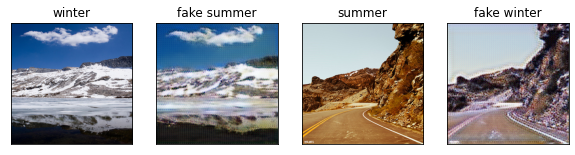

In [ ]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.title("winter")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,2)
plt.imshow(np.moveaxis(np.array(gen_S(winter).cpu().detach()),0,-1))
plt.title("fake summer")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,3)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.title("summer")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,4)
plt.imshow(np.moveaxis(np.array(gen_W(summer).cpu().detach()),0,-1))
plt.title("fake winter")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)